In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
from lsst.daf.butler import Butler
import lsst.geom as geom
import xlens
from xlens.process_pipe.anacal_detect import AnacalDetectPipeConfig, AnacalDetectPipe
from astropy.io import ascii as astascii

from astropy.visualization import ZScaleInterval
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.integrate as integrate
import lsst.afw.image as afwImage
import anacal

In [2]:
obs_repo = '/lustre/work/xiangchong.li/work/hsc_s23b_sim'
obs_collection = 'version1/image'

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry
skymap = obs_butler.get('skyMap', skymap="hsc")

config = AnacalDetectPipeConfig()
config.anacal.force_size = False
config.anacal.num_epochs = 8
config.anacal.num_epochs_deblend = 1
config.anacal.use_average_psf = False
config.anacal.badMaskPlanes = ['BAD', 'CR', 'CROSSTALK', 'NO_DATA', 'REJECTED', 'SAT', 'SUSPECT', 'UNMASKEDNAN', 'SENSOR_EDGE', 'STREAK', 'VIGNETTED']
task = AnacalDetectPipe(config=config)

In [61]:
%%time
import glob
import fitsio

full = fitsio.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim2.fits")
entry = full[8]
tract_id = entry["tract"]
patch_db = entry["patch"]
patch_x = patch_db // 100
patch_y = patch_db % 100
patch_id = patch_x + patch_y * 9
print(tract_id, patch_id)

db_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/"
outdir = f"{db_dir}/s23b-anacal/tracts/{tract_id}/{patch_id}"
out_fname = os.path.join(outdir, "detect.fits")
patch_info = skymap[tract_id][patch_id]
wcs = patch_info.getWcs()
bbox = patch_info.getOuterBBox()
image_dir = (
    "/lustre/HSC_DR/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_calexp"
)
files = glob.glob(os.path.join(image_dir, f"{tract_id}/{patch_id}/i/*"))
fname = files[0]
exposure = afwImage.ExposureF.readFits(fname)
base_dir = "/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/"
mask_dir = f"{base_dir}/s23b-brightStarMask/tracts_mask/{tract_id}/{patch_id}"
mask_fname = os.path.join(mask_dir, "mask.fits")
bmask = fitsio.read(mask_fname)

seed = tract_id * 1000 + patch_id
data = task.anacal.prepare_data(
    exposure=exposure,
    seed=seed,
    noise_corr=None,
    detection=None,
    band=None,
    skyMap=skymap,
    tract=tract_id,
    patch=patch_id,
    star_mask_array=bmask,
)
catalog = task.anacal.run(**data)

8279 67
CPU times: user 36.4 s, sys: 1.01 s, total: 37.4 s
Wall time: 37.9 s


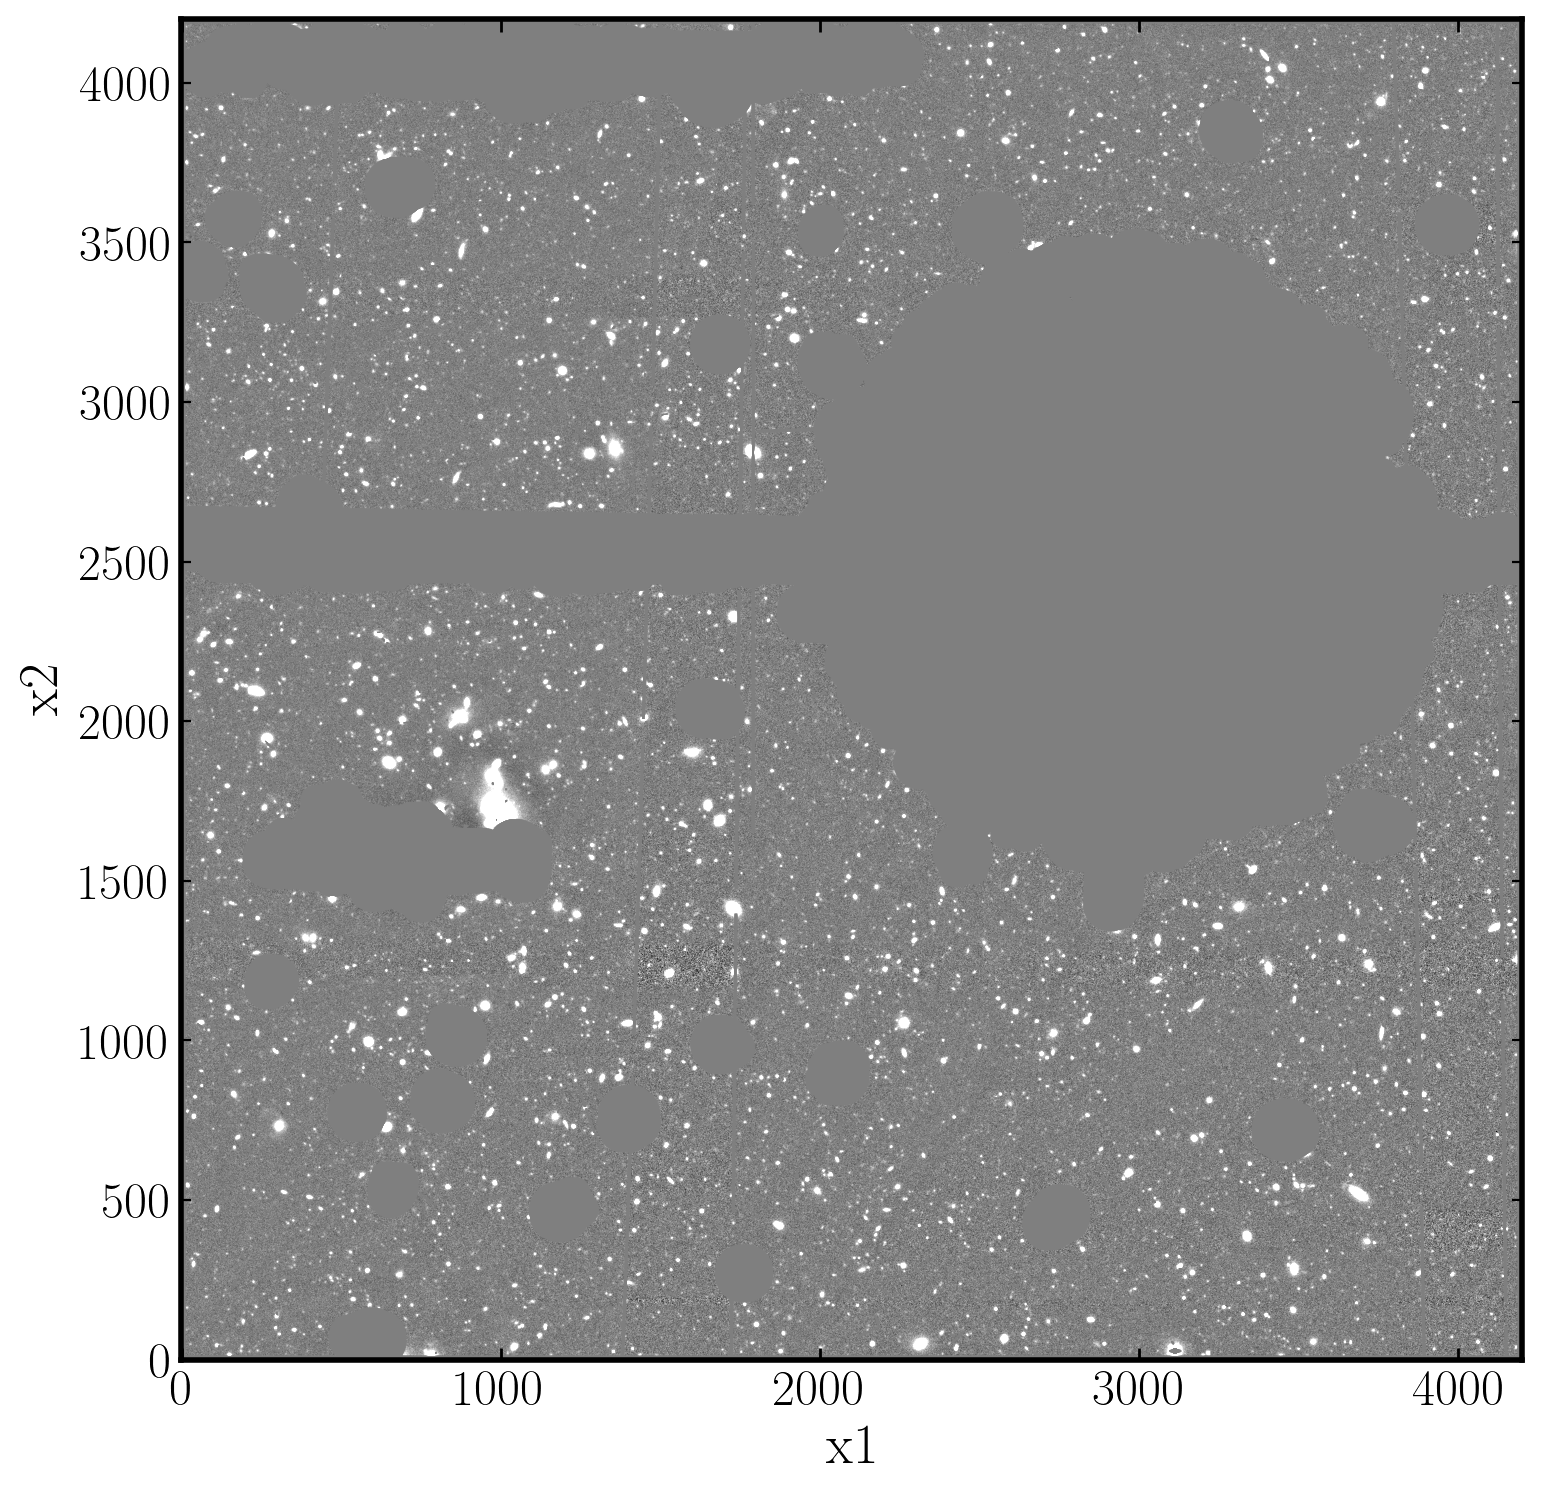

In [62]:
image = data["gal_array"]
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

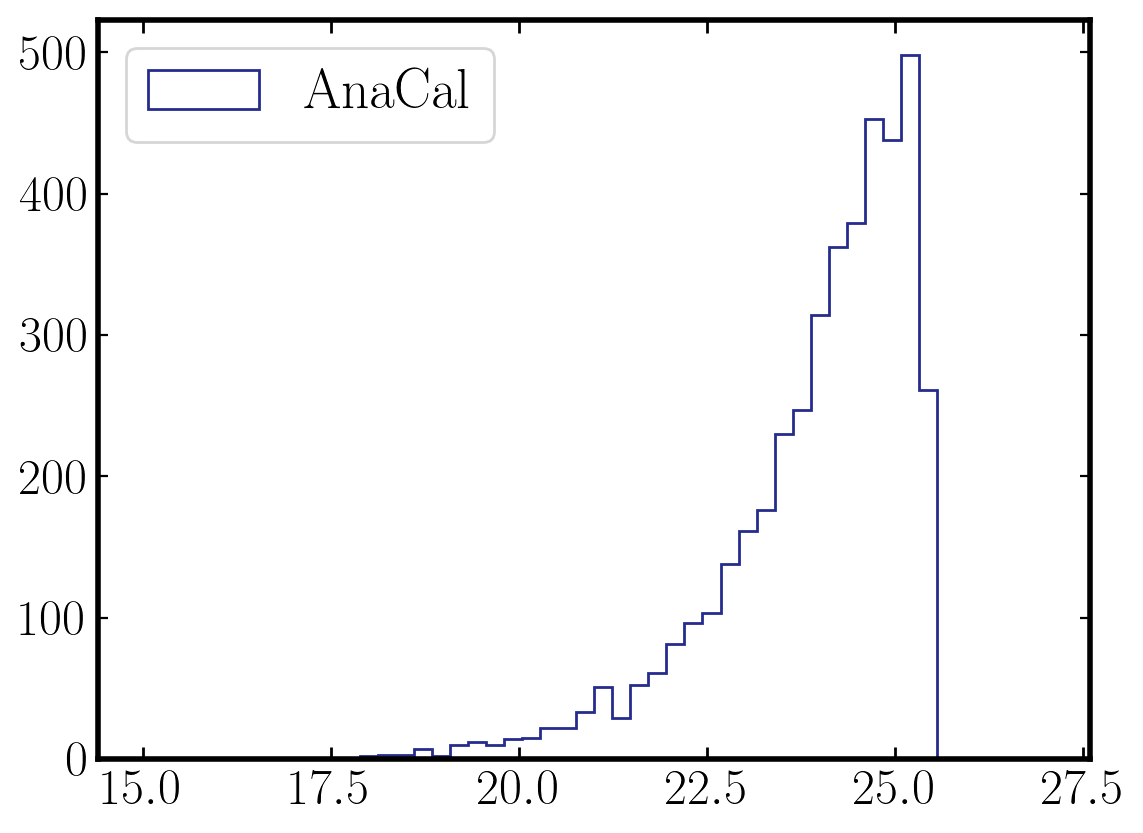

In [35]:
plt.hist(27 - np.log10(catalog["flux"]) * 2.5, histtype="step", density=False, bins=50, range=(15, 27), label="AnaCal")
plt.legend()

-102.0535474372604
93.6081530499557


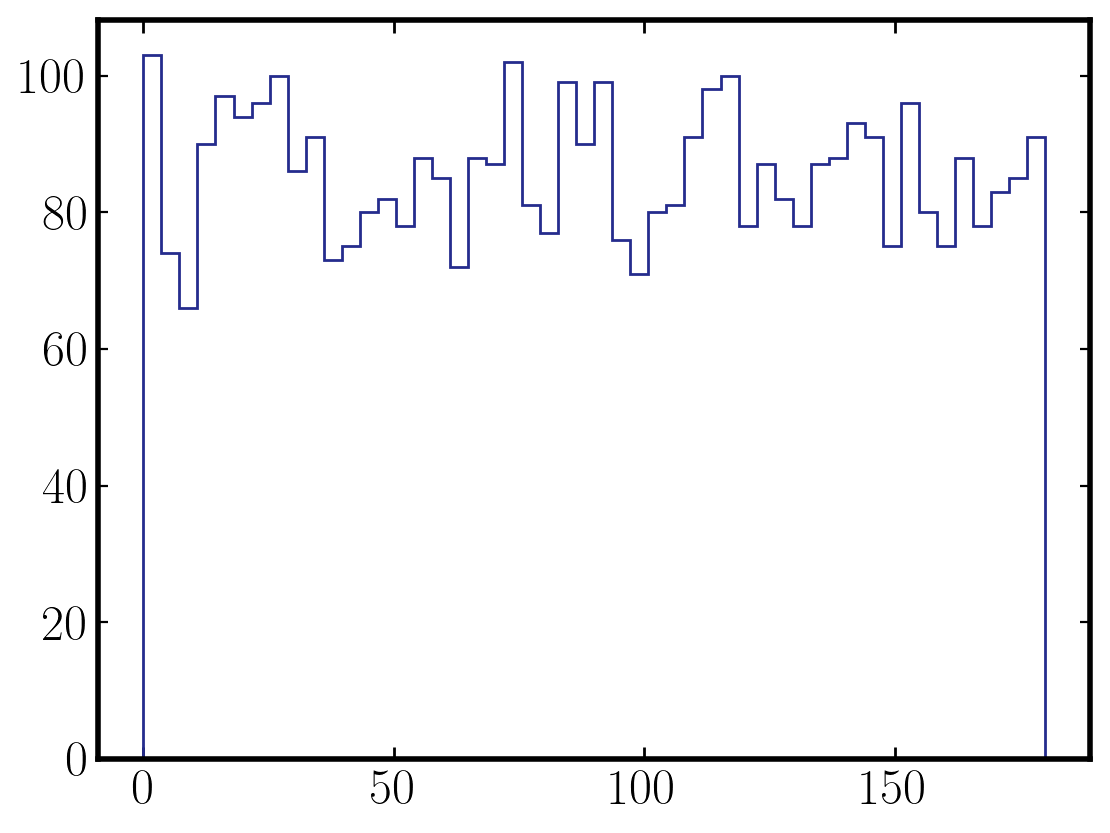

In [36]:
plt.close()
plt.hist(np.degrees(catalog["t"]) % 180, histtype="step", density=False, bins=50)
print(np.min(np.degrees(catalog["t"])))
print(np.max(np.degrees(catalog["t"])))

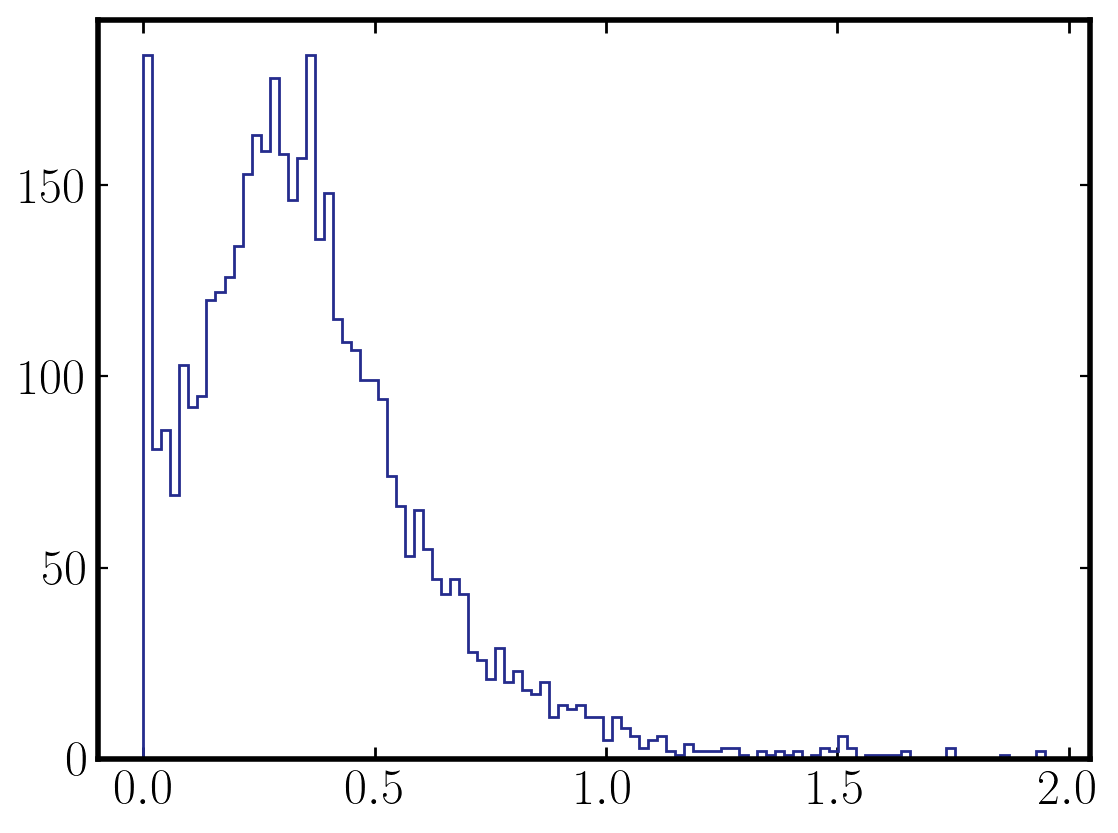

In [37]:
plt.close()
_=plt.hist(np.sqrt(catalog["a1"] **2 + catalog["a2"] **2), histtype="step", density=False, bins=100)

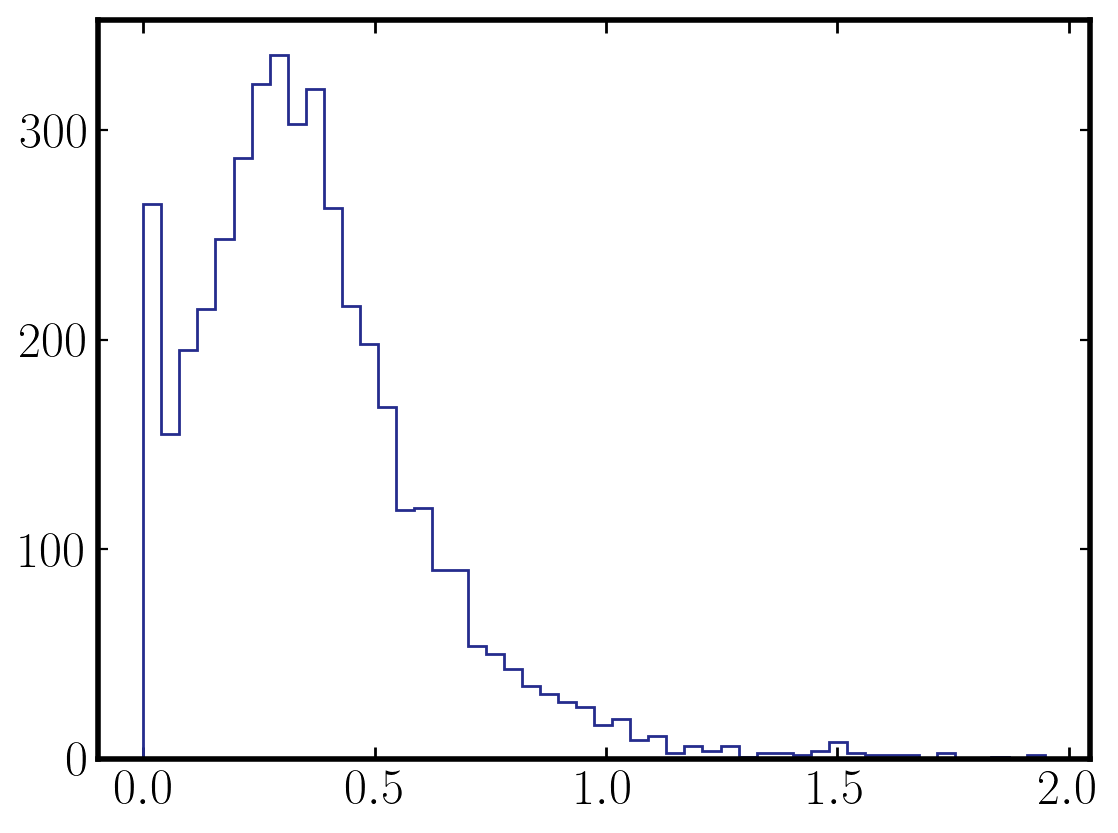

In [38]:
plt.close()
_=plt.hist(np.sqrt(catalog["a2"] ** 2.0 + catalog["a1"] ** 2.0), histtype="step", density=False, bins=50)

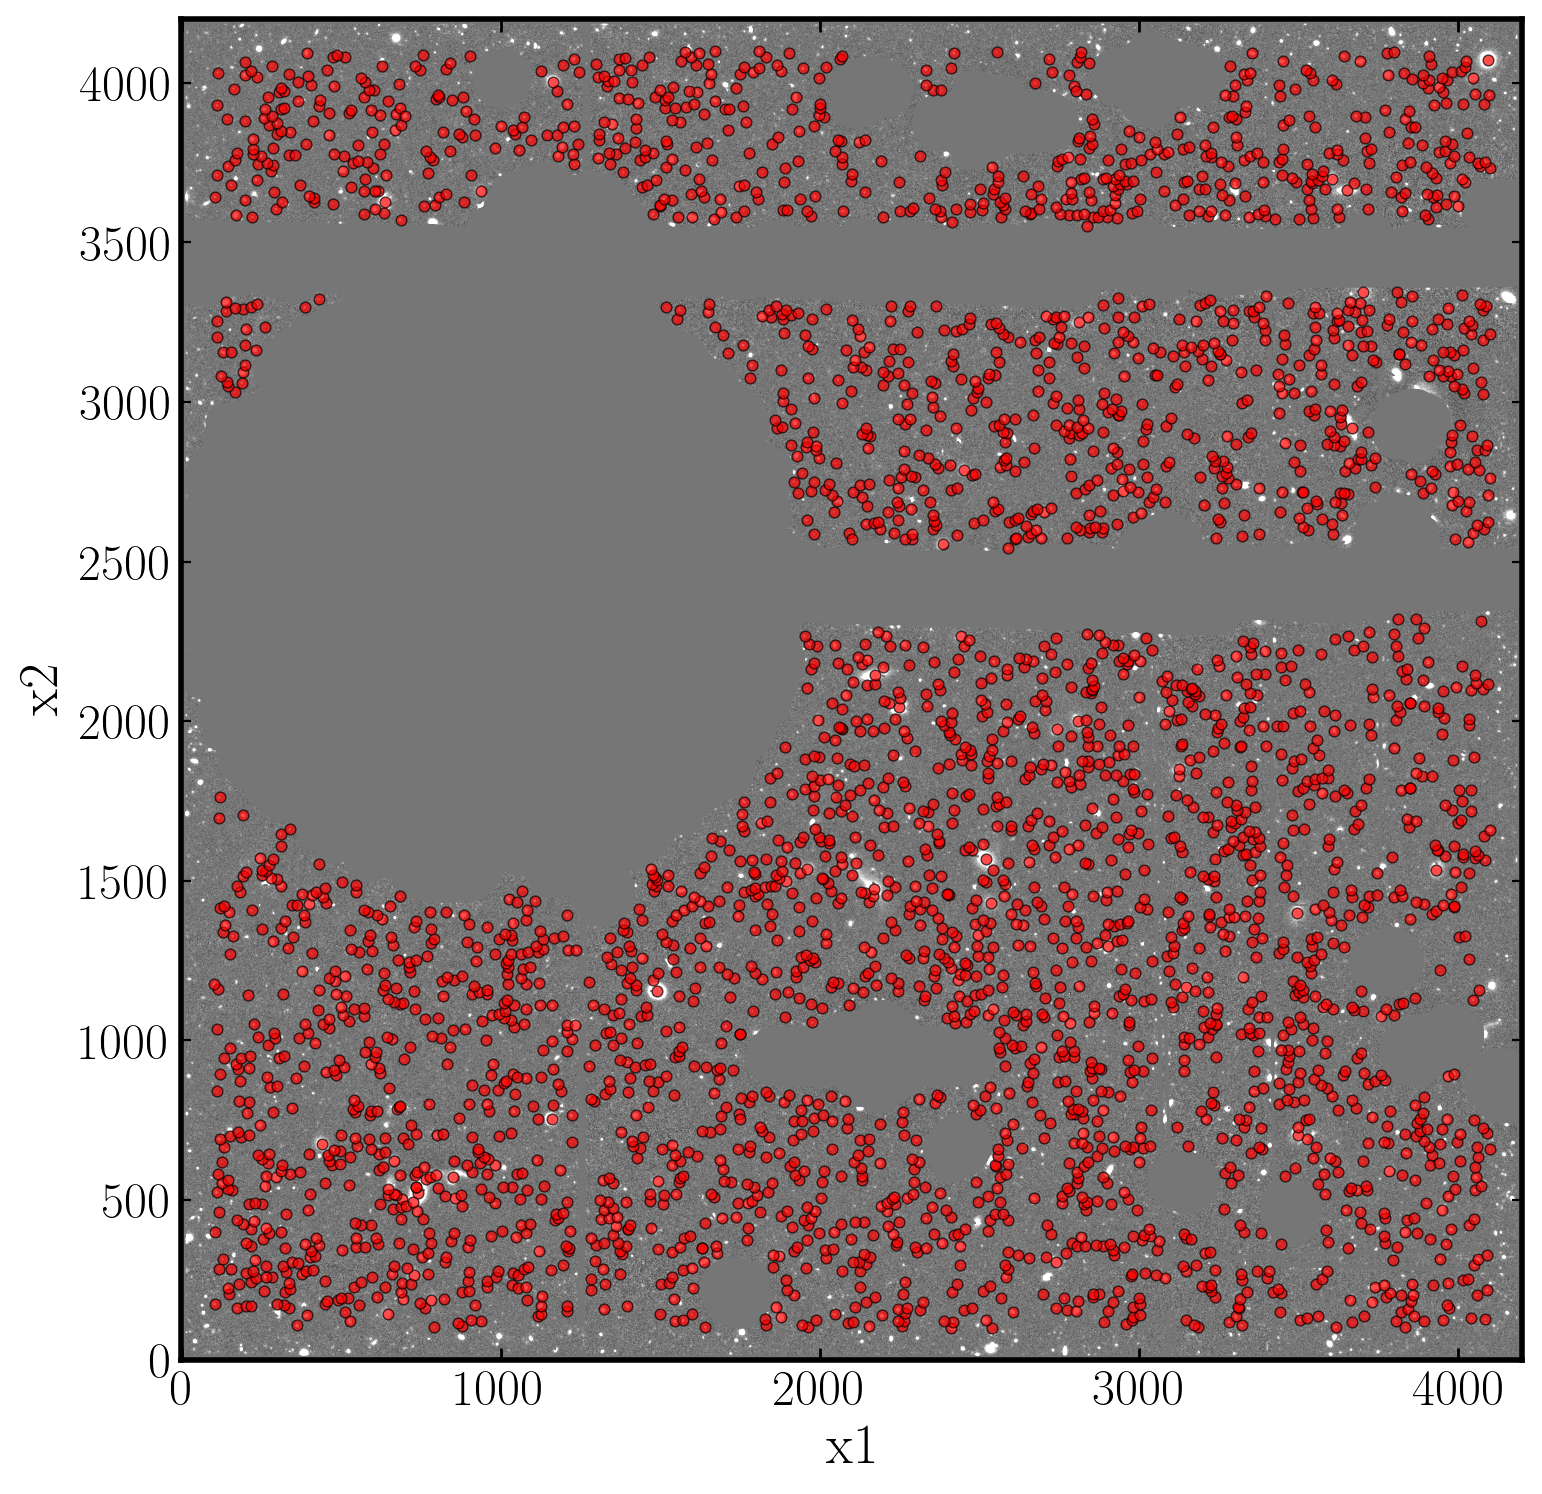

In [42]:
# Example inputs: replace with your actual data
image = data["gal_array"]
gm = (catalog["mask_value"] < 40) & (catalog["is_primary"])
bb = exposure.getBBox()
x1 = catalog["x1"][gm] / 0.168 - bb.beginX
x2 = catalog["x2"] [gm] / 0.168 - bb.beginY

# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.scatter(x1, x2, s=15, c='red', edgecolors='black', linewidths=0.5, alpha=0.7)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

In [50]:
np.min(catalog["x1"]) / 0.168

3941.000000754381

In [49]:
np.min(catalog[catalog["is_primary"]]["x1"]) / 0.168

4003.0000007662493

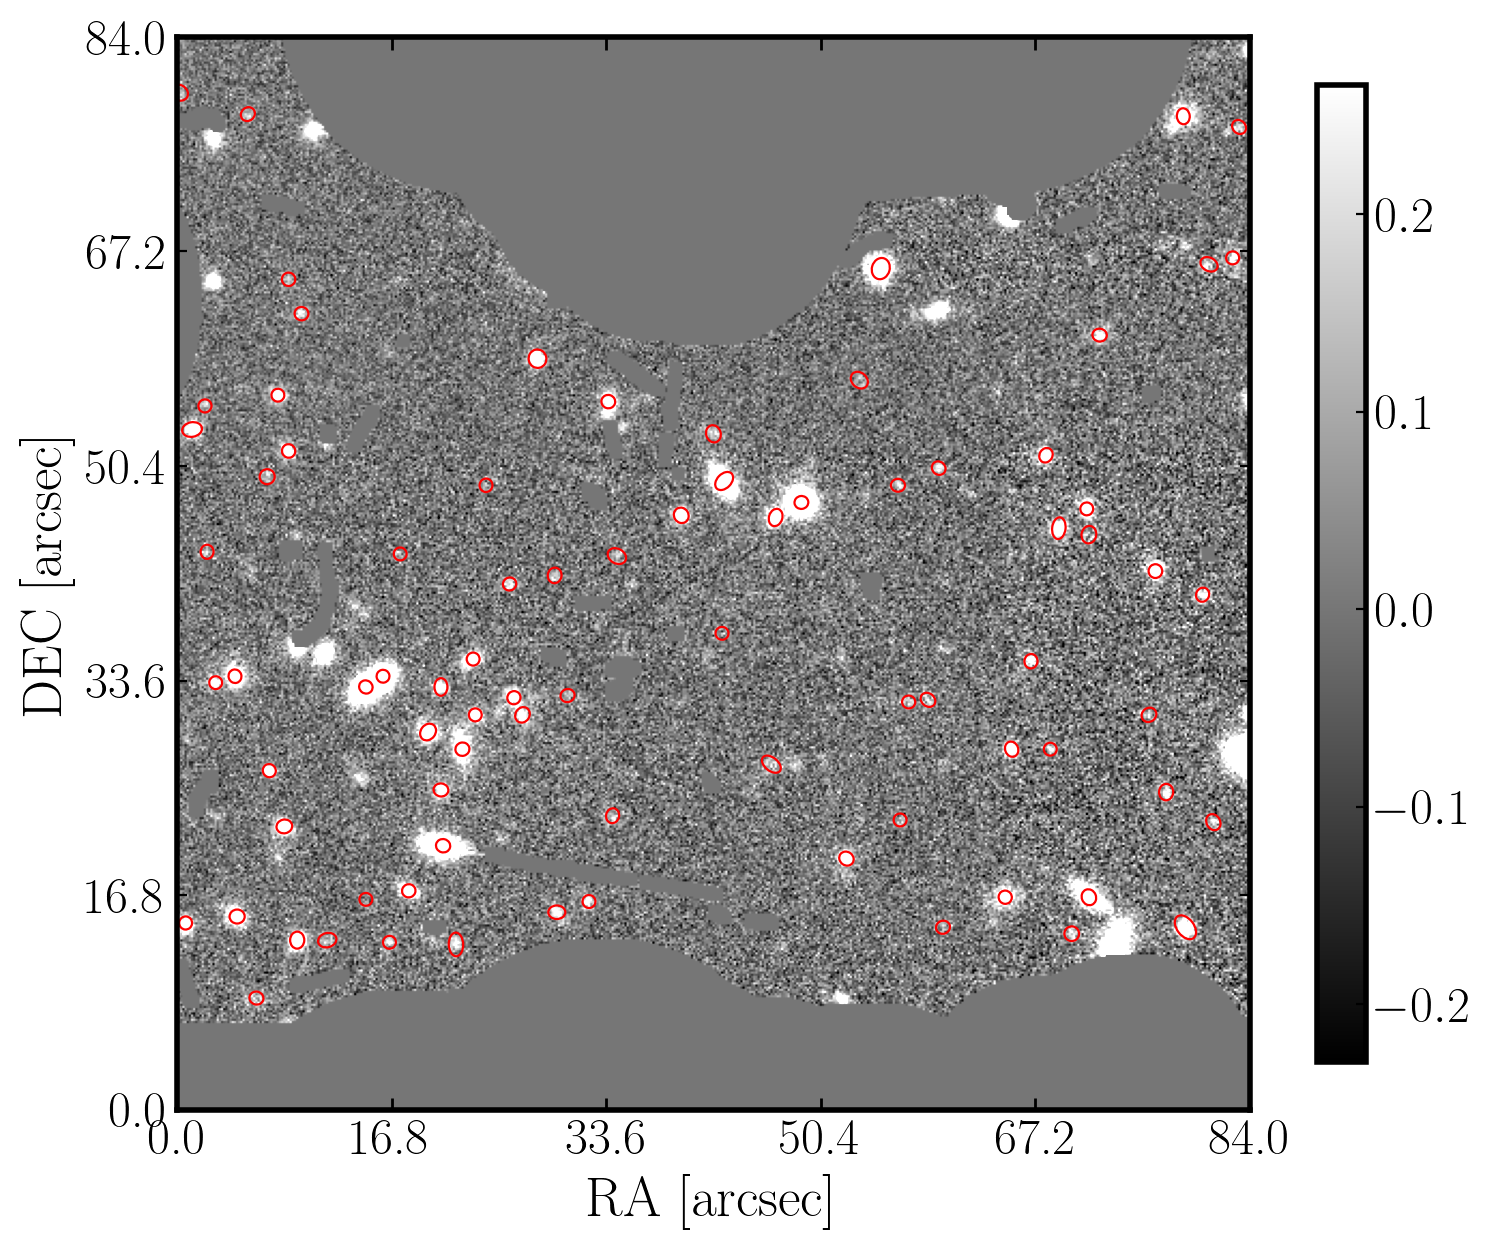

In [40]:
from matplotlib.patches import Ellipse
from matplotlib.collections import PatchCollection

xmin = 2800
ymin = 3500
xmax =xmin+500
ymax = ymin+500
pixel_scale = 0.168
# Example inputs: replace with your actual data
image = data["gal_array"]
gm = (catalog["mask_value"] < 40) 
x1 = catalog["x1"][gm] / pixel_scale - bb.beginX
x2 = catalog["x2"] [gm] / pixel_scale - bb.beginY
msk = (x1> xmin) & (x1< xmax-1) & (x2> ymin-1) & (x2< ymax-1)
x1 = x1[msk] - xmin
x2 = x2[msk] - ymin
a1 = np.sqrt((catalog["a1"][gm] / pixel_scale) **2.0 + 3 ** 2.0)
a2 = np.sqrt((catalog["a2"][gm] / pixel_scale) ** 2.0  + 3 ** 2.0)
theta = catalog["t"][gm] / np.pi * 180.0

# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 7))

im = ax.imshow(image[ymin: ymax, xmin:xmax], origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
patches = [
    Ellipse((xi, yi), width=2*maj, height=2*min_, angle=ang)
    for xi, yi, maj, min_, ang in zip(x1, x2, a1, a2, theta)
]

ax.add_collection(
    PatchCollection(
        patches,
        facecolor='none',
        edgecolor='red',
        linewidth=0.8,
        alpha=1.0,
        zorder=2,
    )
)

pixel_scale = 0.168
xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(xticks)
ax.set_xticklabels([f"{(tick) * pixel_scale:.1f}" for tick in xticks])
ax.set_yticks(yticks)
ax.set_yticklabels([f"{(tick) * pixel_scale:.1f}" for tick in yticks])
ax.set_xlim(0, (xmax - xmin))
ax.set_ylim(0, (ymax - ymin))
ax.set_xlabel("RA [arcsec]")
ax.set_ylabel("DEC [arcsec]")
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.05)
fig.tight_layout()
plt.show()

In [48]:
bbox.getMinX()

3900

In [30]:
e1 = catalog["fpfs_e1"] * catalog["wsel"]
r1 = (
    catalog["fpfs_de1_dg1"] *catalog["wsel"]
    + catalog["dwsel_dg1"] * catalog["fpfs_e1"]
)
print(np.sum(e1) / np.sum(r1))

0.012647300875938178


In [31]:
e1 = catalog["e1"] * catalog["wsel"]
r1 = (
    catalog["de1_dg1"] * catalog["wsel"]
    + catalog["dwsel_dg1"] * catalog["e1"]
)
print(np.sum(e1) / np.sum(r1))

0.011150178153770993
